# 1. Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import time

In [2]:
orig_data = pd.read_csv('/Users/.../.../autos.csv')

In [3]:
orig_data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [4]:
orig_data.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1, inplace=True)

In [5]:
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [6]:
orig_data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [7]:
# 3% of the target have value 0. Will be deleted.

orig_data.query('Price == 0')['Price'].count()/orig_data.shape[0]

0.030397692800442477

In [8]:
data = orig_data.query('Price != 0')

In [9]:
data.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN


In [10]:
def find_missing(data):
    '''
    Return column and percentage of missing values
    '''
    
    count = 0
    for col in data.columns:
        
        pct_missing = np.mean(data[col].isnull())
        if pct_missing > 0:
            count += 1
            print('{} - {}%'.format(col, round(pct_missing*100,1)))
    if count ==0:
        print('No missing values')

        

In [11]:
find_missing(data)

VehicleType - 9.8%
Gearbox - 5.1%
Model - 5.1%
FuelType - 8.6%
NotRepaired - 19.2%


Some features like vehicle type, gearbox, model, fuel type, repair have missed values. 
Let's look at them separately.

In [12]:
data['NotRepaired'].value_counts()

no     243682
yes     34049
Name: NotRepaired, dtype: int64

In [13]:
# Since the question may be ignored by the users, let's put No in the missing values,
# assuming that the car hasn't been repaired

data['NotRepaired'] = data['NotRepaired'].fillna('no')

In [14]:
# 'Small'is a strange category, but it accounts for a third, let it stay like this...

data['VehicleType'].value_counts()

sedan          89405
small          78018
wagon          63701
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

In [15]:
# Fill in the missing values in VehicleType with 'unknown'. 
# The most popular answer is sedan, although sometimes these divisions are quite relative.

data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['VehicleType'].value_counts()

sedan          89405
small          78018
wagon          63701
unknown        33750
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

In [16]:
# There seems to be nothing wrong with the models
data['Brand'].value_counts()

volkswagen        74413
opel              38530
bmw               35809
mercedes_benz     31359
audi              28574
ford              24457
renault           17389
peugeot           10781
fiat               9332
seat               6718
mazda              5465
skoda              5435
smart              5171
citroen            5029
nissan             4807
toyota             4536
hyundai            3533
mini               3165
volvo              3122
mitsubishi         2927
sonstige_autos     2847
honda              2715
kia                2407
suzuki             2273
alfa_romeo         2234
chevrolet          1704
chrysler           1368
dacia               890
daihatsu            775
subaru              735
porsche             734
jeep                658
land_rover          534
daewoo              533
saab                515
trabant             498
jaguar              493
rover               462
lancia              457
lada                213
Name: Brand, dtype: int64

In [17]:
 data['Gearbox'].value_counts()

manual    261373
auto       64869
Name: Gearbox, dtype: int64

In [18]:
# Since most gearboxes are manual, let's fill in 5% of the passes with 'manual' values.

data['Gearbox'] = data['Gearbox'].fillna('manual')
data['Gearbox'].value_counts()

manual    278728
auto       64869
Name: Gearbox, dtype: int64

In [19]:
 data['Model'].value_counts()

golf                  28246
other                 23707
3er                   19179
polo                  12628
corsa                 12197
                      ...  
i3                        8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

In [20]:
data['Model'] = data['Model'].fillna('unknown')
data['Model'].value_counts()

golf                  28246
other                 23707
3er                   19179
unknown               17521
polo                  12628
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 251, dtype: int64

In [21]:
 data['FuelType'].value_counts()

petrol      210765
gasoline     97168
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: FuelType, dtype: int64

In [22]:
# Petrol and gasoline have the same meaning.
# It is also the most common type of fuel. Let's replace gasoline with petrol and fill in missing values with it.

data['FuelType'] = data['FuelType'].replace('gasoline','petrol')
data['FuelType'].fillna('petrol',inplace=True)

In [23]:
find_missing(data)

No missing values


The missing values were filled in on the basis of expected answers of the users (majority answers): fuel typmissing values were filled in with 'unknown'.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343597 non-null  int64 
 1   VehicleType       343597 non-null  object
 2   RegistrationYear  343597 non-null  int64 
 3   Gearbox           343597 non-null  object
 4   Power             343597 non-null  int64 
 5   Model             343597 non-null  object
 6   Kilometer         343597 non-null  int64 
 7   FuelType          343597 non-null  object
 8   Brand             343597 non-null  object
 9   NotRepaired       343597 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.8+ MB


### Anomalies in the quantitative values of the features

In [25]:
data['RegistrationYear'].value_counts()

2000    23072
1999    21995
2005    21524
2006    19679
2001    19654
        ...  
1931        1
1927        1
1925        1
3200        1
4100        1
Name: RegistrationYear, Length: 140, dtype: int64

In [26]:
# В данных о годах есть странные года, избавимся от них

data.query('RegistrationYear < 1900 or RegistrationYear > 2020')['VehicleType'].count()

139

In [27]:
data  = data.query('1900 < RegistrationYear < 2020')

<AxesSubplot:>

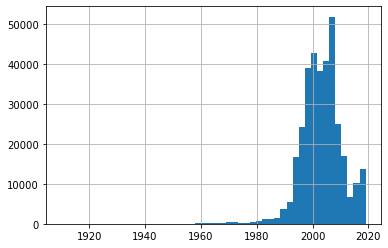

In [28]:
data['RegistrationYear'].hist(bins=50)

<AxesSubplot:xlabel='RegistrationYear'>

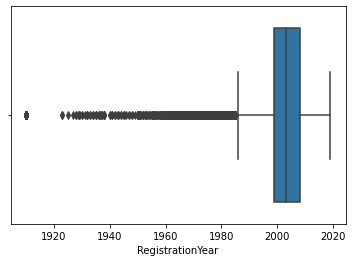

In [29]:
sns.boxplot(data['RegistrationYear'])

Number of anomalies:  5604


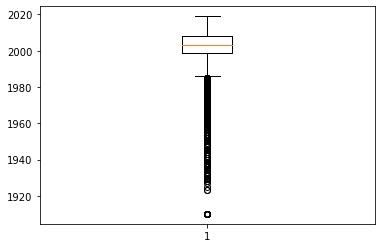

In [30]:
boxplot = plt.boxplot(data['RegistrationYear'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
df_outliers = data[data['RegistrationYear'].isin(outliers)]

print("Number of anomalies: ", len(df_outliers))

In [31]:
data = data.query('RegistrationYear > 1985  and  RegistrationYear < 2020')

Most vehicles were registered between 1985 and around 2020.

<AxesSubplot:>

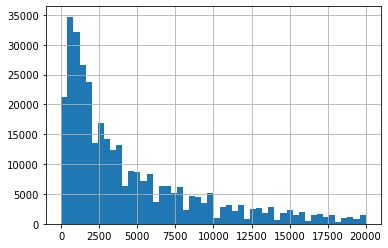

In [32]:
data['Price'].hist(bins=50)

<AxesSubplot:xlabel='Price'>

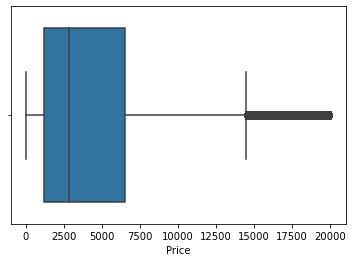

In [33]:
sns.boxplot(data['Price'])

<AxesSubplot:>

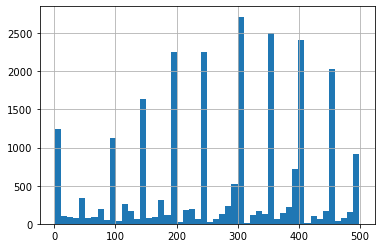

In [34]:
data.query('0 < Price < 500')['Price'].hist(bins=50)

In [35]:
data.query('0 < Price < 500')['Price'].count()/data.shape[0]

0.07358503969170115

In [36]:
# Since the data is most likely from the European market, the small price of a used car is acceptable.
data.query('0 < Price < 100')['Price'].count()

2371

In [37]:
data = data.query('Price > 100')

<AxesSubplot:xlabel='Power'>

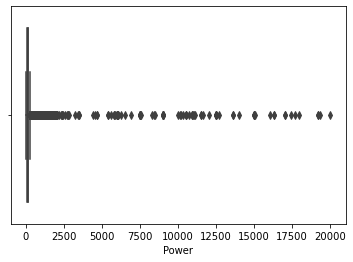

In [38]:
sns.boxplot(data['Power'])

In [39]:
# Let's look at the engine power. It depends on the type of fuel

data.query('Power > 1000')['Power'].count()

273

In [40]:
data = data.query('Power < 1000')

<AxesSubplot:xlabel='Power'>

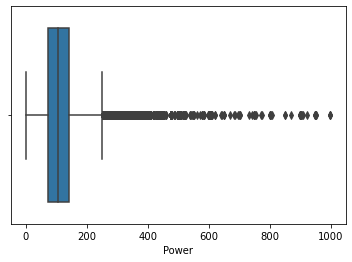

In [41]:
sns.boxplot(data['Power'])

In [42]:
# As can be seen in 10% of cases the vehicle power is 0, most likely it was forgotten to specify
data.query('Power == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,no
32,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,manual,0,kangoo,150000,petrol,renault,no
54,4700,wagon,2005,manual,0,signum,150000,petrol,opel,no
55,550,wagon,1999,manual,0,astra,150000,petrol,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354336,3299,unknown,2005,auto,0,outlander,150000,petrol,mitsubishi,no
354338,180,unknown,1995,manual,0,unknown,125000,petrol,opel,no
354346,2600,unknown,2005,auto,0,c_klasse,150000,petrol,mercedes_benz,no
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


In [43]:
# Replace the zero power values with the median value depending on the vehicle type
data['Power'] = data.groupby('VehicleType')['Power'].transform(lambda x: x.replace(0,x.median()))


In [44]:
data.query('Power == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired


<AxesSubplot:>

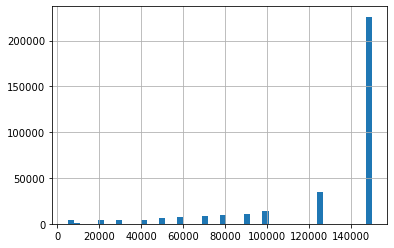

In [45]:
# Mileage values indicate that most cars with 150,000 km mileage

data['Kilometer'].hist(bins = 50)

In [46]:
print("In comparision to original data {:.2f}% of data was deleted".format((orig_data.shape[0] - data.shape[0]) * 100 / orig_data.shape[0]))


In comparision to original data 5.69% of data was deleted


In [47]:
data.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,75,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334198 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             334198 non-null  int64 
 1   VehicleType       334198 non-null  object
 2   RegistrationYear  334198 non-null  int64 
 3   Gearbox           334198 non-null  object
 4   Power             334198 non-null  int64 
 5   Model             334198 non-null  object
 6   Kilometer         334198 non-null  int64 
 7   FuelType          334198 non-null  object
 8   Brand             334198 non-null  object
 9   NotRepaired       334198 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.0+ MB


The data is ready. We use several models: Linear Regressor, Random Forest Regressor, LGBM.

For each model we will make a feature conversion.

#  2. Model Training and Testing

### Constant model

In [49]:
target_test = data['Price']

In [50]:
target_pred_constant = pd.Series(data['Price'].median(), index=target_test.index)

In [51]:
rmse = mse(target_test, target_pred_constant) ** 0.5
print("RMSE of constant model:", rmse)

RMSE of constant model: 4799.384939848917


### Linear regression

In [52]:
data_lr = data.copy()

In [53]:
ohe_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
data_ohe = pd.get_dummies(data_lr,columns = ohe_columns, drop_first=True)

In [54]:
data_ohe.head(5)

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,480,1993,75,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [55]:
features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(
    data_ohe.drop('Price', axis=1), data_ohe['Price'], test_size=0.25, random_state=42)


In [56]:
# Scaling of quantitative features

numeric = ['RegistrationYear','Power','Kilometer']

scaler = StandardScaler()
scaler.fit(features_ohe_train[numeric])
features_ohe_train[numeric] = scaler.transform(features_ohe_train[numeric])
features_ohe_test[numeric] = scaler.transform(features_ohe_test[numeric])

In [57]:
start = time.time()

lr = LinearRegression(n_jobs = -1)

lr.fit(features_ohe_train, target_ohe_train)

finish = time.time()
lr_fit = finish - start

In [58]:
start = time.time()

lr_predictions = lr.predict(features_ohe_test)

finish = time.time()
lr_pred = finish - start

In [59]:
rmse_lr = mse(target_ohe_test, lr_predictions) ** 0.5
print("RMSE Linear Regression:", rmse_lr)

RMSE Linear Regression: 2454.274031677193


### Random forest

In [60]:
data_rf = data.copy()

In [61]:
data_rf.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,75,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


In [62]:
cat = []
for col in data_rf.columns:
    if data_rf[col].dtype == 'object':
        cat.append(col)
    

In [63]:
cat

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [64]:
# Ordinal encoding only for categorical columns

data_rf[cat] = OrdinalEncoder().fit_transform(data_rf[cat])

In [65]:
features_enc_train, features_enc_test, target_enc_train, target_enc_test = train_test_split(
    data_rf.drop('Price', axis=1), data_rf['Price'], test_size=0.25, random_state=42)


In [66]:
parameters = {'n_estimators':[150,200], 'max_depth':[2,4,7]}
rf = RandomForestRegressor(random_state=42)
clf = GridSearchCV(rf, parameters, scoring = 'neg_mean_squared_error',n_jobs = -1, verbose = 2)
clf.fit(features_enc_train, target_enc_train)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.5min finished


{'max_depth': 7, 'n_estimators': 200}
-4386807.96706841


In [67]:
start = time.time()

rf = RandomForestRegressor(n_estimators = 200, max_depth = 7, random_state=42, n_jobs=-1)
rf.fit(features_enc_train, target_enc_train)
finish = time.time()
rf_pred = finish - start

In [68]:
start = time.time()

rf_predictions = rf.predict(features_enc_test)
rmse_rf = mse(target_enc_test, rf_predictions) ** 0.5
print("RMSE Random Forest Regressor:", rmse_rf)

finish = time.time()
rf_fit = finish - start

RMSE Random Forest Regressor: 2098.7518962336617


### LightGBM

In [69]:
lgb_model = LGBMRegressor(n_estimators=100, random_state= 42,n_jobs=- 1, silent=True)

In [70]:
param_grid = {
    'learning_rate': [0.01, 0.5],
    'num_leaves': [32, 100]
    }

grid_lg = GridSearchCV(estimator = lgb_model, param_grid = param_grid, cv=5, verbose= False, scoring = 'neg_mean_squared_error')

grid_lg.fit(features_enc_train,target_enc_train)

print(grid_lg.best_params_)

{'learning_rate': 0.5, 'num_leaves': 100}


In [71]:
lgb_model = LGBMRegressor(n_estimators=100, random_state= 42,n_jobs=- 1, silent=True, learning_rate = 0.5, num_leaves = 100)

In [72]:
start = time.time()

lgb_model.fit(features_enc_train, target_enc_train)

finish = time.time()
lgb_fit = finish - start

In [73]:
start = time.time()
predictions_lgb = lgb_model.predict(features_enc_test)
rmse_lgb = mse(target_enc_test, predictions_lgb) ** 0.5
print("RMSE LightGBM:", rmse_lgb)
finish = time.time()
lgb_pred = finish - start

RMSE LightGBM: 1579.4218287869828


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

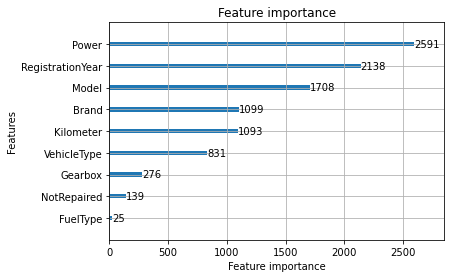

In [74]:
lgb.plot_importance(lgb_model)

In [75]:
columns = ['Linear Regressor','Random Forest Regressor', 'LightGBM Regressor']
index = ['RMSE','Learn time','Prediction time']
data = [[rmse_lr,rmse_rf, rmse_lgb],[lr_fit, rf_fit, lgb_fit],[lr_pred, rf_pred, lgb_pred]]
time_data = pd.DataFrame(data = data,index = index, columns = columns)

In [76]:
time_data

,Linear Regressor,Random Forest Regressor,LightGBM Regressor
RMSE,2454.274032,2098.751896,1579.421829
Learn time,6.286393,0.426952,1.974262
Prediction time,0.221919,43.092325,0.314458


## Result:

Data was preprocessed for model training. Three models were trained : Linear Regressor, Random Forest Regressor, Light GBM Rgressor. LightGBM model has the lowest RMSE metric and good performance time. 
The distribution of car prices is skewed, with most cars priced between 0 and 5000, so the error of 1600 euros is significant.
It is necessary to clarify the acceptable rate of prediction and model learning for the customer. 